<a href="https://colab.research.google.com/github/EricRibeiroAlves/Interacao-Humano-Robo/blob/main/Codigo/%5BAP_T%5D_Eric_Modelo_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Legenda**:
- $dt$: Passo de tempo (incremento de tempo entre as amostras).
- $t$: Tempo total (ou carimbo de tempo) da amostra.
- $\frac{d\tau_{r}}{dt}$ [R_d_T]: Derivada do torque do robô (variação do torque com o tempo).
- $\tau_{r}$ [R_T]: Torque do robô.
- $S_Fx$ [R_Fx]: Sensor de torque Tx.
- $\omega_{l}$ [R_w_l]: Velocidade da coroa.
- $\theta_{l}$ [R_t_l]: Ângulo da coroa.
- $\omega_{h}$ [R_w_p]: Velocidade da pessoa.
- $\theta_{h}$ [R_t_p]: Ângulo da pessoa.
- $∫e(Interacao).dt$ [R_i_T_e]: Integral do erro de torque.
- $U(x)$ [R_u]: Sinal de controle.
- $\tau^{d}_{r}$ [R_T_d]: Torque desejado do robô.
- $\theta_{m}$ [R_t_m]: Ângulo do motor.
- $\frac{d\omega_{l}}{dt}$ [R_d_w_l]: Derivada da velocidade da coroa (variação da velocidade da coroa com o tempo).
- $phase$: Fase do movimento ou do ciclo (possivelmente relacionada à fase da marcha).
- $\theta_{m, L}$ [L_t_m]: Ângulo do motor na perna esquerda.
- $\theta_{l, L}$ [L_t_l]: Ângulo da coroa na perna esquerda.
- $L_u$: Sinal de controle aplicado ao lado esquerdo.
- $\tau_{r, L}$ [L_T_r]: Torque real no lado esquerdo.
- $\tau^{d}_{r, L}$ [L_T_d]: Torque desejado no lado esquerdo.

### Variáveis adicionais (não presentes no dataset mas relevantes no código):
- $\tau_{i}$ [R_T_i]: Torque de interação.

# Bibliotecas

In [2]:
# Trato dos dados
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

# Libs p/ Modelo Deep LTSM
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import Huber
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 1º Passo: Montar o Drive e carregar o dataset


In [3]:
drive.mount('/content/drive')
t6_markov = "drive/MyDrive/Markov/T6/last_data_MarkovMao 1.dat"
head_markov = ['dt', 't', 'R_d_T', 'R_T', 'R_Fx',
               'R_w_l', 'R_t_l', 'R_w_p', 'R_t_p',
               'R_i_T_e', 'R_u', 'R_T_d', 'R_t_m',
               'R_d_w_l', 'phase', 'L_t_m', 'L_t_l',
               'L_u', 'L_T_r', 'L_T_d']
pd.set_option('display.float_format', lambda x: '%.10f' % x)
markov_t6 = pd.read_table(t6_markov, header=None, names=head_markov, index_col=False)

Mounted at /content/drive


In [4]:
data = markov_t6.iloc[1275:]
# Remover linhas onde R_w_l é zero
data = data.loc[data['R_w_l'] != 0]

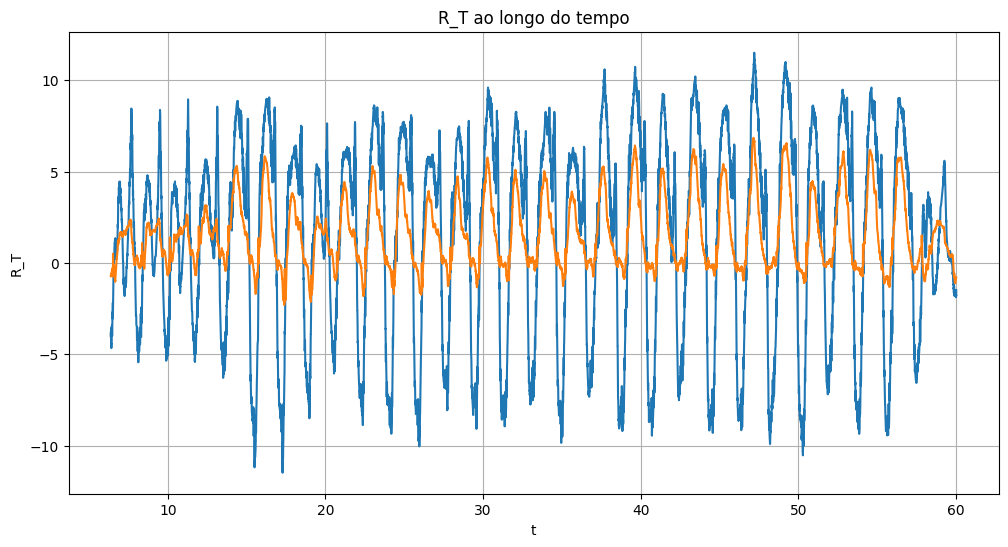

In [5]:
# Gráfico de linha para uma coluna
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(data['t'].iloc[:], data['R_T'].iloc[:])
plt.plot(data['t'].iloc[:], data['R_T_d'].iloc[:])
plt.title('R_T ao longo do tempo')
plt.xlabel('t')
plt.ylabel('R_T')
plt.show()

# 2º Passo: Cálculo (Markov 6, Dados Completos)

In [18]:
Ka = 200  # Rigidez do acessório
Ba = 10   # Amortecimento do acessório
# Calcule τi e sua derivada
data['tau_i'] = Ka * (data['R_t_p'] - data['R_t_l']) + Ba * (data['R_w_p'] - data['R_w_l'])
data['d_tau_i'] = np.gradient(data['tau_i']) / np.gradient(data['t'])


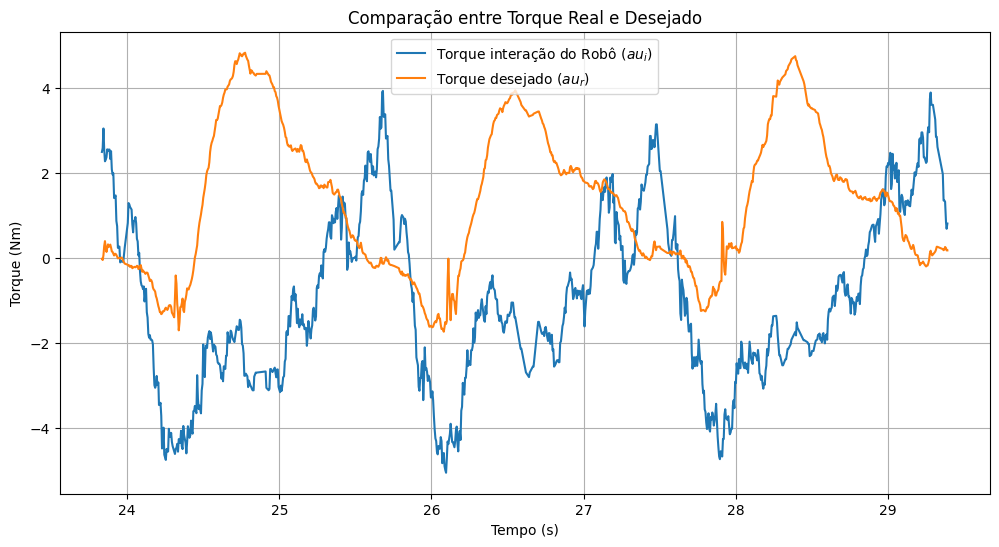

In [24]:
# prompt: plot

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(data['t'].iloc[3000:4000], (data['tau_i'].iloc[3000:4000])/20, label='Torque interação do Robô ($\tau_i$)')
plt.plot(data['t'].iloc[3000:4000], data['R_T_d'].iloc[3000:4000], label='Torque desejado ($\tau_r$)')

plt.xlabel('Tempo (s)')
plt.ylabel('Torque (Nm)')
plt.title('Comparação entre Torque Real e Desejado')
plt.legend()
plt.grid(True)
plt.show()

# 3º Passo: Separação e Normalização dos dados


In [25]:
dataset = data.copy()
X = dataset[['R_t_p', 'R_t_l', 'R_w_p', 'R_w_l', 'phase']]  # Inputs
y = dataset[['R_T_d']]  # Saída: torque desejado (já calculado pelo sistema)
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# 4º Passo: Criar sequências de dados para LSTM

In [26]:
timesteps = 350  # Ajustar conforme a análise
n_features = X_scaled.shape[1]

def create_sequences(X, y, timesteps):
    Xs, ys = [], []
    for i in range(len(X) - timesteps):
        Xs.append(X[i:i+timesteps])
        ys.append(y[i+timesteps])
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(X_scaled, y_scaled, timesteps)
print("Forma dos dados de entrada para LSTM:", X_train.shape)
print("Forma dos dados de saída:", y_train.shape)

Forma dos dados de entrada para LSTM: (9143, 350, 5)
Forma dos dados de saída: (9143, 1)


# 5º Passo: Definição do Modelo LSTM otimizado

In [27]:
model_lstm = Sequential()
model_lstm.add(LSTM(128, return_sequences=True, input_shape=(timesteps, n_features)))
model_lstm.add(Dropout(0.2))  # Dropout reduzido para 20%

model_lstm.add(LSTM(64, return_sequences=False))  # Camada final com 32 unidades
model_lstm.add(Dropout(0.2))

model_lstm.add(Dense(1))  # Saída de um único valor (tau_r)

# Compilar o modelo com Huber loss e Adam com learning rate ajustado
model_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=Huber(),
    metrics=['MAE', 'MSE'])

# Resumo do modelo
model_lstm.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 350, 128)            │          68,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 350, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,081 (461.25 KB)

 Trainable params: 118,081 (461.25 KB)

 Non-trainable params: 0 (0.00 B)

# 6º Passo: Treinamento do Modelo

In [29]:
history = model_lstm.fit(
    X_train, y_train,
    epochs=256,
    batch_size=32,
    validation_split=0.4,
    verbose = 1
)

Epoch 1/256
172/172 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - MAE: 0.0356 - MSE: 0.0022 - loss: 0.0011 - val_MAE: 0.0564 - val_MSE: 0.0056 - val_loss: 0.0028
Epoch 2/256
172/172 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - MAE: 0.0349 - MSE: 0.0022 - loss: 0.0011 - val_MAE: 0.0706 - val_MSE: 0.0098 - val_loss: 0.0049
Epoch 3/256
172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - MAE: 0.0337 - MSE: 0.0020 - loss: 0.0010 - val_MAE: 0.0604 - val_MSE: 0.0060 - val_loss: 0.0030
Epoch 4/256
172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - MAE: 0.0356 - MSE: 0.0022 - loss: 0.0011 - val_MAE: 0.0549 - val_MSE: 0.0046 - val_loss: 0.0023
Epoch 5/256
172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - MAE: 0.0334 - MSE: 0.0019 - loss: 9.6612e-04 - val_MAE: 0.0564 - val_MSE: 0.0052 - val_loss: 0.0026
Epoch 6/256
172/172 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - MAE: 0.0327 - MSE: 0.0019 - loss: 9.5707e-04 - val_MAE: 0.0572 - val_MSE: 0.0055 - val_loss: 0.0027
Epoch 7/256
172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - MAE: 0.0314 - MSE: 0.

# 7º Passo: Avaliação e Previsão

In [30]:
y_pred_scaled = model_lstm.predict(X_train)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_train_rescaled = scaler_y.inverse_transform(y_train)

# Métricas adicionais
r2 = r2_score(y_train_rescaled, y_pred)
mae = mean_absolute_error(y_train_rescaled, y_pred)
rmse = np.sqrt(mean_squared_error(y_train_rescaled, y_pred))

print(f'R²: {r2}')
print(f'MAE: {mae:.4f} Nm')
print(f'RMSE: {rmse:.4f} Nm')

286/286 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
R²: 0.9492128146799483
MAE: 0.2439 Nm
RMSE: 0.4124 Nm


# 8º Passo: Visualização das perdas (train vs validation)

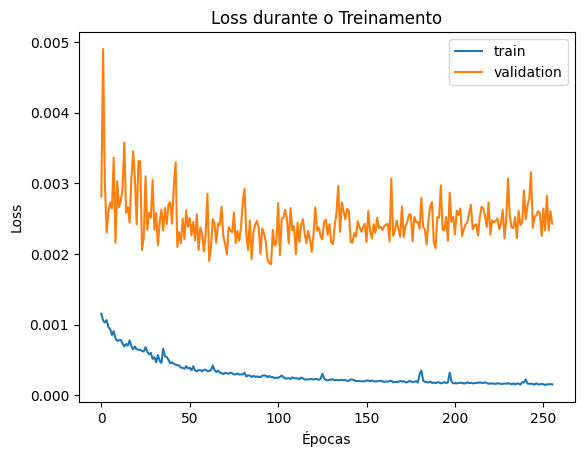

In [31]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title("Loss durante o Treinamento")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.show()

# 9º Passo: Gráfico comparativo entre valores reais e previsões

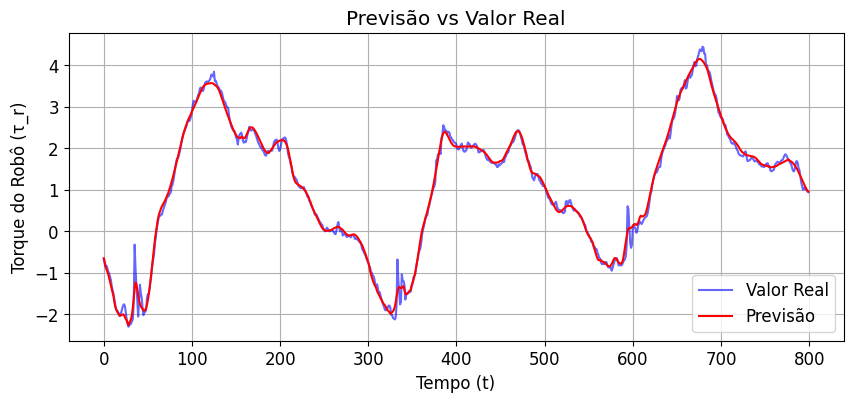

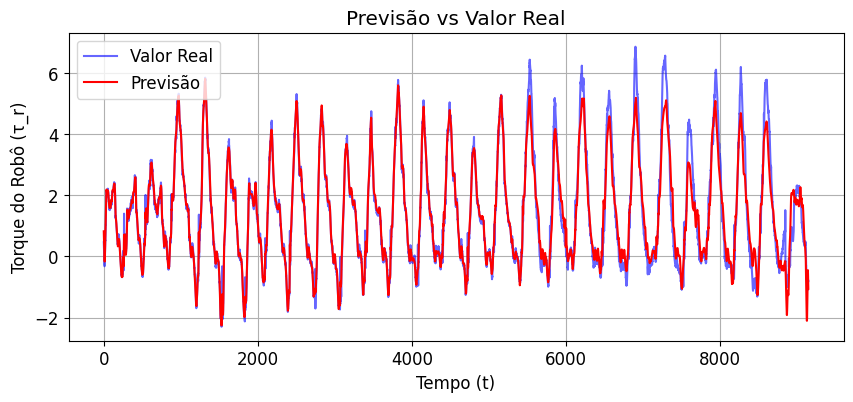

In [37]:
def plot_predictions(y_true, y_pred, title='Previsão vs Valor Real'):
    plt.figure(figsize=(10, 4))
    plt.plot(y_true.flatten(), label='Valor Real', color='blue', alpha=0.6)
    plt.plot(y_pred.flatten(), label='Previsão', color='red', linestyle='-', alpha=1)
    plt.title(title)
    plt.xlabel('Tempo (t)')
    plt.ylabel('Torque do Robô (τ_r)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Exibir previsões vs valores reais para uma parte do dataset
plot_predictions(y_train_rescaled[1500:2300], y_pred[1500:2300])
plot_predictions(y_train_rescaled[:], y_pred[:])



# 10º Passo: Erro

In [33]:
# Calcular o erro como a diferença entre os valores reais e preditos
erro = y_train_rescaled.flatten() - y_pred.flatten()

#11º Passo: Plot do Erro

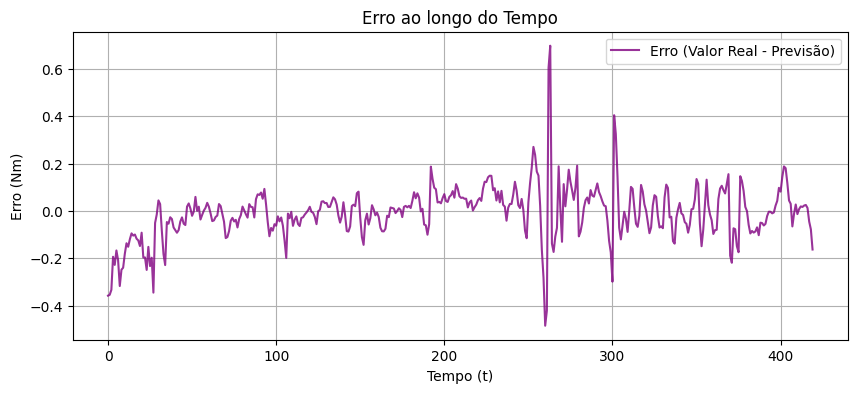

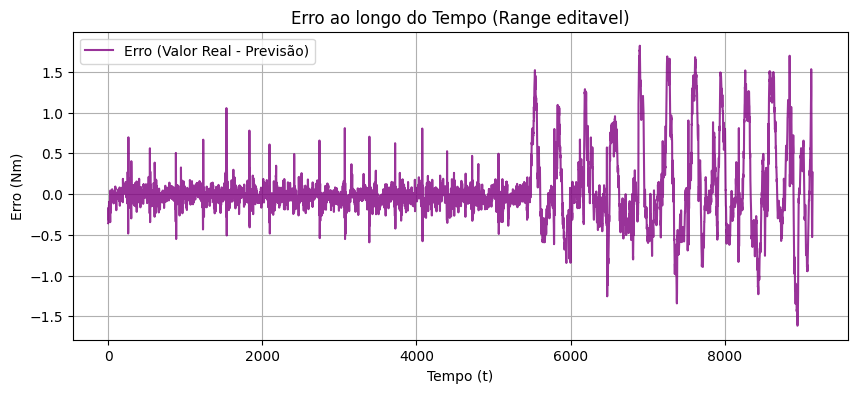

Média do Erro: 0.0305 Nm
Desvio Padrão do Erro: 0.4113 Nm


In [34]:
# Plotar o erro no tempo
plt.figure(figsize=(10, 4))
plt.plot(erro[:420], label='Erro (Valor Real - Previsão)', color='purple', alpha=0.8)
plt.title('Erro ao longo do Tempo')
plt.xlabel('Tempo (t)')
plt.ylabel('Erro (Nm)')
plt.legend()
plt.grid(True)
plt.show()

# Exibir o erro apenas para uma janela de tempo específica (por exemplo, primeiros 3000 pontos)
plt.figure(figsize=(10, 4))
plt.plot(erro[:], label='Erro (Valor Real - Previsão)', color='purple', alpha=0.8)
plt.title('Erro ao longo do Tempo (Range editavel)')
plt.xlabel('Tempo (t)')
plt.ylabel('Erro (Nm)')
plt.legend()
plt.grid(True)
plt.show()

# Estatísticas do erro
mean_error = np.mean(erro)
std_error = np.std(erro)
print(f'Média do Erro: {mean_error:.4f} Nm')
print(f'Desvio Padrão do Erro: {std_error:.4f} Nm')

In [38]:
model_lstm.evaluate(X_train, y_train, verbose=2)

286/286 - 3s - 11ms/step - MAE: 0.0266 - MSE: 0.0020 - loss: 0.0010


[0.0010142431128770113, 0.02663176693022251, 0.0020284862257540226]

In [46]:
model_lstm.save('drive/MyDrive/Markov/Modelo LSTM/model_lstm_Markov6.h5')
model_lstm.save_weights('drive/MyDrive/Markov/Modelo LSTM/model_lstm_weights_Markov6.weights.h5')
json_string = model_lstm.to_json()

'{"module": "keras", "class_name": "Sequential", "config": {"name": "sequential", "trainable": true, "dtype": {"module": "keras", "class_name": "DTypePolicy", "config": {"name": "float32"}, "registered_name": null}, "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_shape": [null, 350, 5], "dtype": "float32", "sparse": false, "name": "input_layer"}, "registered_name": null}, {"module": "keras.layers", "class_name": "LSTM", "config": {"name": "lstm", "trainable": true, "dtype": {"module": "keras", "class_name": "DTypePolicy", "config": {"name": "float32"}, "registered_name": null}, "return_sequences": true, "return_state": false, "go_backwards": false, "stateful": false, "unroll": false, "zero_output_for_mask": false, "units": 128, "activation": "tanh", "recurrent_activation": "sigmoid", "use_bias": true, "kernel_initializer": {"module": "keras.initializers", "class_name": "GlorotUniform", "config": {"seed": null}, "registered_name": null}, "recurrent_in